In [4]:
%%writefile project.cpp

#include <cmath>
#include <stdio.h>
#include <stdlib.h>
#include <iostream>

using namespace std;

struct solution {
    double* ksi;
    double* omega;
    double* gamma;
    double* psi;
};

solution solver(double t, int Nt, int Nh, double B) {
    double N = Nh;
    double tau = t / Nt;
    double h = 1 / N;
    double* ksi = new double[Nh];
    ksi[0] = 0;
    for (int i = 1; i < Nh; ++i){
        ksi[i] = ksi[i-1] + h;
    }
    double* omega = new double[Nh];
    for (int i = 0; i < Nh-1; ++i){
        omega[i] =  sqrt(1 - ksi[i]);
        //cout << i << " " << ksi[i] << " " << sqrt(1 - ksi[i]) << endl;
    }
    omega[Nh-1] = 0;

    double gamma = 0.1;
    double v = pow(omega[Nh-2],2)*omega[Nh-3]/gamma/2/h;
    double* gammaArr = new double[Nt];
    gammaArr[0] = gamma;
    double* psiArr = new double[Nt];
    psiArr[0] = -pow((omega[0] + omega[1])/2, 3)/gamma*((omega[1] - omega[0])/h - gamma*B);

    double* omega_new = new double[Nh];
    omega_new[0] = 1;
    omega_new[Nh-1] = 0;

    for (int k = 0; k < Nt; ++k){
        for (int j = 1; j < Nh-1; ++j){
            omega_new[j] = omega[j] + tau*((1/gamma*v*ksi[j])*(omega[j + 1] - omega[j])/h - 
                                        1/gamma/h * ( -pow(omega[j+1] + omega[j], 3)/8/gamma * ((omega[j+1] - omega[j])/h - gamma * B) + 
                                                    pow(omega[j-1] + omega[j],3)/8/gamma * ((omega[j] - omega[j-1])/h - gamma * B)));
        }
        v = -pow(omega_new[Nh-2],2)/gamma*((omega_new[Nh-1] - omega_new[Nh-3])/2/h - gamma*B);
        gamma = gamma + tau*v;
        gammaArr[k+1] = gamma;
        psiArr[k+1] = -pow((omega_new[0] + omega_new[1])/2, 3)/gamma*((omega_new[1] - omega_new[0])/h - gamma*B);
        for (int j = 1; j < Nh-1; ++j){
            omega[j] = omega_new[j];
            //cout << omega[j] << " ";
        }
        //cout << endl;
    }
    return {ksi, omega, gammaArr, psiArr};
}

int main(int argc, char** argv) {
    int Nt = strtol(argv[1], NULL, 10);
    int Nh = strtol(argv[2], NULL, 10);
    int t_max = strtol(argv[3], NULL, 10);
    double B = -1;
    solution sol = solver(t_max, Nt, Nh, B);
    /*cout << "solution" << endl;
    for (int j = 0; j < Nh + 1; ++j){
            cout << sol.omega[j] << " ";
    }*/
    //cout << endl;
    return 0;
}

Overwriting project.cpp


In [2]:
%%writefile project_openmp.cpp

#include <cmath>
#include <stdio.h>
#include <stdlib.h>
#include <iostream>
#include <omp.h>

using namespace std;

struct solution {
    double* ksi;
    double* omega;
    double* gamma;
    double* psi;
};

solution solver(double t, int Nt, int Nh, double B, int num_thr) {

    omp_set_dynamic(0);
    omp_set_num_threads(num_thr);
    
    int tid = omp_get_thread_num();


    double N = Nh;
    double tau = t / Nt;
    double h = 1 / N;
    double* ksi = new double[Nh + 1];
    ksi[0] = 0;

    #pragma omp for 
    for (int i = 1; i < Nh + 1; ++i){
        ksi[i] = ksi[i-1] + h;
    }

    double* omega = new double[Nh + 1];

    #pragma omp for 
    for (int i = 0; i < Nh; ++i){
        omega[i] =  sqrt(1 - ksi[i]);
    }
    omega[Nh] = 0;

    double gamma = 0.1;
    double v = pow(omega[Nh-1],2)*omega[Nh-2]/gamma/2/h;
    double* gammaArr = new double[Nt + 1];
    gammaArr[0] = gamma;
    double* psiArr = new double[Nt + 1];
    psiArr[0] = -pow((omega[0] + omega[1])/2, 3)/gamma*((omega[1] - omega[0])/h - gamma*B);

    double* omega_new = new double[Nh + 1];
    omega_new[0] = 1;
    omega_new[Nh] = 0;

    for (int k = 0; k < Nt; ++k){

        #pragma omp parallel
        {
            #pragma omp for
            for (int j = 1; j < Nh; ++j){
                omega_new[j] = omega[j] + tau*((1/gamma*v*ksi[j])*(omega[j + 1] - omega[j])/h - 
                                            1/gamma/h * ( -pow(omega[j+1] + omega[j], 3)/8/gamma * ((omega[j+1] - omega[j])/h - gamma * B) + 
                                                        pow(omega[j-1] + omega[j],3)/8/gamma * ((omega[j] - omega[j-1])/h - gamma * B)));
            }
            v = -pow(omega_new[Nh-1],2)/gamma*((omega_new[Nh] - omega_new[Nh-2])/2/h - gamma*B);
            gamma = gamma + tau*v;
            gammaArr[k+1] = gamma;
            psiArr[k+1] = -pow((omega_new[0] + omega_new[1])/2, 3)/gamma*((omega_new[1] - omega_new[0])/h - gamma*B);

            #pragma omp for
            for (int j = 1; j < Nh; ++j){
                omega[j] = omega_new[j];
            }
        }
    }
    return {ksi, omega, gammaArr, psiArr};
}

int main(int argc, char** argv) {
    int Nt = strtol(argv[1], NULL, 10);
    int Nh = strtol(argv[2], NULL, 10);
    int t_max = strtol(argv[3], NULL, 10);
    int num_thr = strtol(argv[4], NULL, 10);
    double B = -1;
    solution sol = solver(t_max, Nt, Nh, B, num_thr);
    /*cout << "solution" << endl;
    for (int j = 0; j < Nh + 1; ++j){
            cout << sol.omega[j] << " ";
    }
    cout << endl;*/
    return 0;
}

Overwriting project_openmp.cpp


In [ ]:
%%writefile project_mpi.cpp

#include <mpi.h>
#include <cmath>
#include <stdio.h>
#include <stdlib.h>
#include <iostream>

using namespace std;

int main(int argc, char** argv) {
    int Nt = strtol(argv[1], NULL, 10);
    int Nh = strtol(argv[2], NULL, 10);
    int t_max = strtol(argv[3], NULL, 10);
    double B = -1;

    int prank;
    int psize;
    MPI_Status status;

    MPI_Init(&argc, &argv);

    MPI_Comm_size(MPI_COMM_WORLD, &psize);
    MPI_Comm_rank(MPI_COMM_WORLD, &prank);

    double N = Nh;
    double tau = t_max / Nt;
    double h = 1 / (N - 1);

    int N_per_rank = Nh/psize;
    if (prank == psize - 1){
        N_per_rank = N_per_rank + Nh % psize;
    } 
    int N_per_rank_0 = Nh/psize;

    double* ksi = new double[N_per_rank];

    for (int i = 0; i < N_per_rank; ++i){
        ksi[i] = h * (N_per_rank_0 * prank + i);
        //cout << prank << " " << ksi[i] << endl;
    }

    double* omega = new double[N_per_rank];
    for (int i = 0; i < N_per_rank; ++i){
        omega[i] =  sqrt(1 - ksi[i]);
        //cout << prank << " " << omega[i] << endl;
    }

    double gamma = 0.1;
    double v = pow(omega[Nh-2],2)*omega[Nh-3]/gamma/2/h;
    double* gammaArr = new double[Nt + 1];
    double* psiArr = new double[Nt + 1];
    if (prank == 0){    
        gammaArr[0] = gamma;
        psiArr[0] = -pow((omega[0] + omega[1])/2, 3)/gamma*((omega[1] - omega[0])/h - gamma*B);
    }
    double* omega_new = new double[N_per_rank];
    if (prank == 0){
        omega_new[0] = 1;
    }
    if (prank == psize - 1){
        omega_new[Nh - 1] = 0;
    }

    for (int k = 0; k < Nt; ++k){

        double omega_next;
        double omega_prev;

        // sending start of the array
        if (prank != 0){
            int dest = prank - 1;
            //cout << "sending start from " << prank << " to " << dest << endl;
            MPI_Send(&omega[0], 1, MPI_DOUBLE, dest, k, MPI_COMM_WORLD);

        }

        // getting start of the array
        if (prank != psize - 1){
            int source = prank + 1;
            //cout << "getting start from " << source << " to " << prank << endl;
            MPI_Recv(&omega_next, 1, MPI_DOUBLE, source, k, MPI_COMM_WORLD, &status);
        }


        // sending end of the array
        if (prank != psize - 1){
            int dest = prank + 1;
            //cout << "sending end from " << prank << " to " << dest << endl;
            MPI_Send(&omega[N_per_rank - 1], 1, MPI_DOUBLE, dest, k, MPI_COMM_WORLD);
        }

        // getting end of the array
        if (prank != 0){
            int source = prank - 1;
            //cout << "getting start from " << source << " to " << prank << endl;
            MPI_Recv(&omega_prev, 1, MPI_DOUBLE, source, k, MPI_COMM_WORLD, &status);
        }
        //cout << prank << " " << ksi[0] <<  " " << omega_next << " " << omega_prev << endl;

        if (prank != 0){
            int j = 0;
            omega_new[j] = omega[j] + tau*((1/gamma*v*ksi[j])*(omega[j + 1] - omega[j])/h - 
                                        1/gamma/h * ( -pow(omega[j+1] + omega[j], 3)/8/gamma * ((omega[j+1] - omega[j])/h - gamma * B) + 
                                                    pow(omega_prev + omega[j],3)/8/gamma * ((omega[j] - omega_prev)/h - gamma * B)));
        }

        if (prank != psize - 1){
            int j = N_per_rank - 1;
            omega_new[j] = omega[j] + tau*((1/gamma*v*ksi[j])*(omega[j + 1] - omega[j])/h - 
                                        1/gamma/h * ( -pow(omega_next + omega[j], 3)/8/gamma * ((omega_next - omega[j])/h - gamma * B) + 
                                                    pow(omega[j-1] + omega[j],3)/8/gamma * ((omega[j] - omega[j-1])/h - gamma * B)));
        }

        for (int j = 1; j < N_per_rank - 1; ++j){
            omega_new[j] = omega[j] + tau*((1/gamma*v*ksi[j])*(omega[j + 1] - omega[j])/h - 
                                        1/gamma/h * ( -pow(omega[j+1] + omega[j], 3)/8/gamma * ((omega[j+1] - omega[j])/h - gamma * B) + 
                                                    pow(omega[j-1] + omega[j],3)/8/gamma * ((omega[j] - omega[j-1])/h - gamma * B)));
        }

        double v;
        if (prank == psize - 1){
            v = -pow(omega_new[N_per_rank-2],2)/gamma*((omega_new[N_per_rank - 1] - omega_new[N_per_rank - 3])/2/h - gamma*B);
        }

        MPI_Bcast(&v, 1, MPI_DOUBLE, psize - 1, MPI_COMM_WORLD);

        if (prank == 0){
            gamma = gamma + tau*v;
            gammaArr[k+1] = gamma;
            psiArr[k+1] = -pow((omega_new[0] + omega_new[1])/2, 3)/gamma*((omega_new[1] - omega_new[0])/h - gamma*B);
        }
        
        for (int j = 0; j < N_per_rank; ++j){
            omega[j] = omega_new[j];
            //cout << omega[j] << " ";
        }
        //cout << endl;
        MPI_Barrier(MPI_COMM_WORLD);
    }
    

    //sol = solver(t_max, Nt, Nh, B);
    /*cout << "solution" << endl;
    for (int j = 0; j < N_per_rank; ++j){
        cout << prank << " " << omega[j] << endl;
    }*/
    //cout << endl;

    MPI_Finalize();
    return 0;
}

In [ ]:
!mpic++ project_mpi.cpp -o project_mpi

In [ ]:
!g++ -o project project.cpp

In [3]:
!g++ -o project_openmp -fopenmp project_openmp.cpp

In [32]:
%%timeit -r 5 -n 2
!./project 100000 1000 0.00000001

6.2 s ± 107 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [38]:
%%timeit -r 5 -n 2
!./project_openmp 100000 1000 0.00000001 2

3.78 s ± 259 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [35]:
%%timeit -r 5 -n 2
!mpirun -n 2 ./project_mpi 100000 1000 0.00000001

3.99 s ± 189 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
nonparallel = 6.2
openmp = np.array([6.2, 3.78, 2.87, 2.57])
MPI = np.array([6.2, 3.99, 3.44, 3.19])
threads = np.array([1,2,3,4])

In [26]:
font = {'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

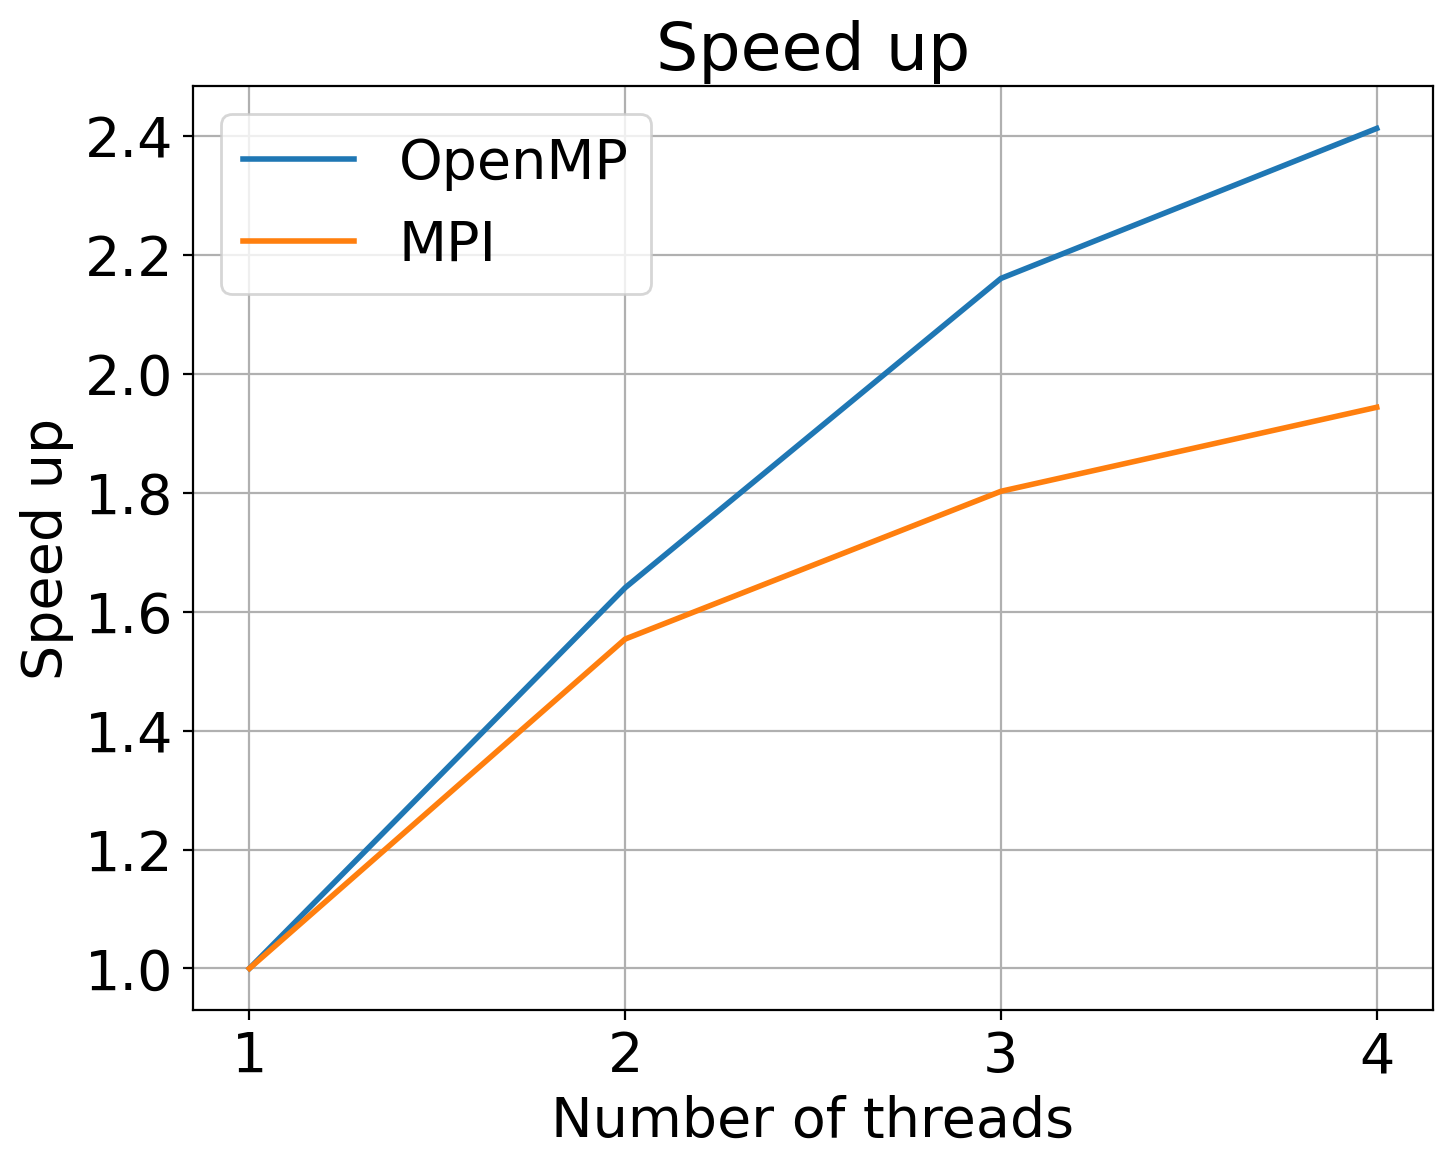

In [40]:
plt.figure(figsize = (8,6), dpi = 200)
plt.plot(threads, nonparallel / openmp, label = 'OpenMP', lw = 2)
plt.plot(threads, nonparallel / MPI, label = 'MPI', lw = 2)
plt.xticks(threads)
plt.legend()
plt.grid()
plt.xlabel('Number of threads')
plt.ylabel('Speed up')
plt.title('Speed up')
plt.savefig('MPI_OpenMP.png')